# Imports and data load

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from dataclasses import dataclass
from warnings import filterwarnings
import kaggle_evaluation.default_inference_server

filterwarnings("ignore")

DATA_ROOT = Path("/kaggle/input/hull-tactical-market-prediction/")

train_pd = pd.read_csv(DATA_ROOT / "train.csv").dropna()
train_pl = pl.read_csv(DATA_ROOT / "train.csv")

train_pd.head()

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
6969,6969,0,0,0,0,0,-1,0,0,0,...,0.976852,0.996693,0.534651,0.884921,-0.911387,0.979167,-0.847754,0.001145,0.000040,0.000797
6970,6970,0,0,0,0,0,0,0,1,0,...,0.986772,0.997354,0.283256,0.769180,-0.842354,0.970238,-0.821913,0.004738,0.000040,0.004390
6971,6971,0,0,0,0,1,0,0,1,0,...,0.962963,0.999339,0.713303,0.814153,-0.933089,0.951720,-0.817906,0.006016,0.000040,0.005669
6972,6972,0,0,0,0,1,0,1,1,0,...,0.946429,1.000000,0.583019,0.809524,-1.051731,0.953042,-0.887412,0.001414,0.000039,0.001067
6973,6973,0,0,0,0,1,0,0,0,1,...,0.960979,0.999339,1.054972,0.567460,-1.138938,0.951058,-0.930502,-0.007182,0.000039,-0.007529


# Distribution of forward_returns and market_forward_excess_returns

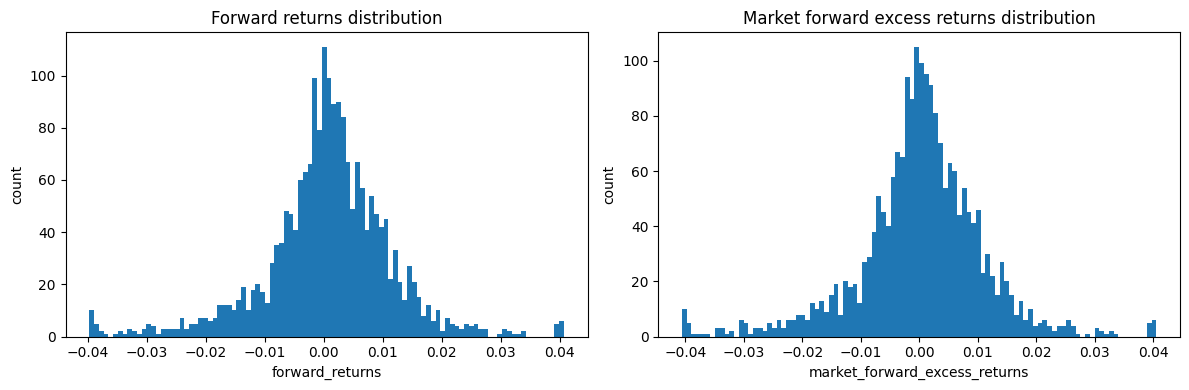

In [2]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(train_pd["forward_returns"], bins=100)
axes[0].set_title("Forward returns distribution")
axes[0].set_xlabel("forward_returns")
axes[0].set_ylabel("count")

axes[1].hist(train_pd["market_forward_excess_returns"], bins=100)
axes[1].set_title("Market forward excess returns distribution")
axes[1].set_xlabel("market_forward_excess_returns")
axes[1].set_ylabel("count")

plt.tight_layout()
plt.show()

You’ll typically see heavy mass near 0, with relatively small positive/negative tails.

If the distribution is roughly symmetric around 0 with small mean, that tells you the edge is tiny; any model has to extract very weak signals.

Comparing forward_returns vs market_forward_excess_returns shows how much of the action is in the market vs idiosyncratic stuff.

# Time series of forward_returns and risk_free_rate

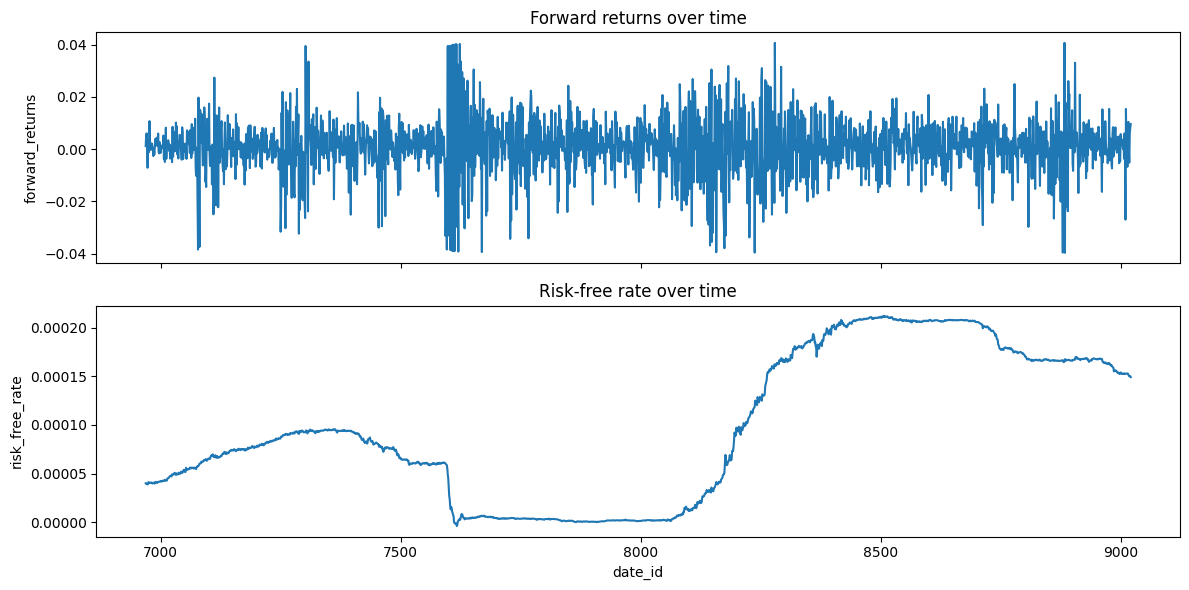

In [3]:
sample = train_pd.sort_values("date_id")[["date_id", "forward_returns", "risk_free_rate"]].copy()

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].plot(sample["date_id"], sample["forward_returns"])
axes[0].set_title("Forward returns over time")
axes[0].set_ylabel("forward_returns")

axes[1].plot(sample["date_id"], sample["risk_free_rate"])
axes[1].set_title("Risk-free rate over time")
axes[1].set_xlabel("date_id")
axes[1].set_ylabel("risk_free_rate")

plt.tight_layout()
plt.show()

forward_returns will look like noisy high-frequency fluctuations.

risk_free_rate typically drifts slowly; much smoother and lower variance.

This makes it obvious why your strategy is a mix of “risk-free” and “risky” asset: you’re trying to time when to shift into forward returns vs sit in risk-free.

# Correlation heatmap for key features + target

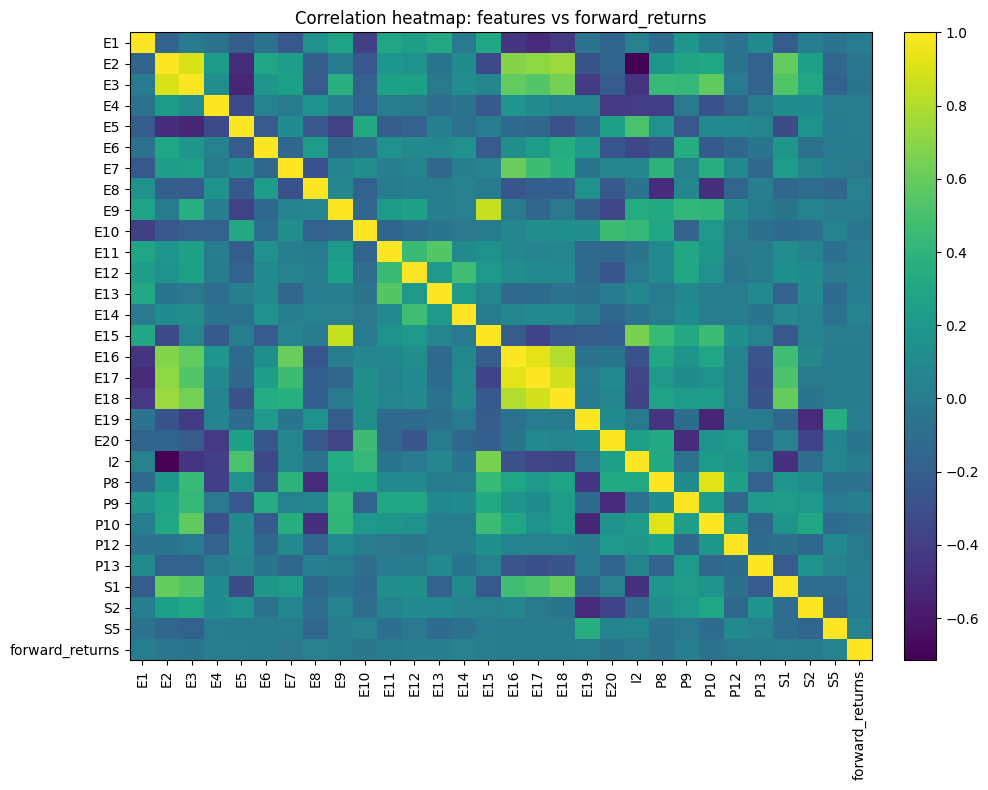

In [4]:
feature_cols = [
    "E1", "E2", "E3", "E4", "E5", "E6", "E7", "E8", "E9", "E10",
    "E11", "E12", "E13", "E14", "E15", "E16", "E17", "E18", "E19", "E20",
    "I2", "P8", "P9", "P10", "P12", "P13", "S1", "S2", "S5"
]

corr_df = train_pd[feature_cols + ["forward_returns"]].corr()

plt.figure(figsize=(10, 8))
im = plt.imshow(corr_df.values, aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr_df.columns)), corr_df.columns, rotation=90)
plt.yticks(range(len(corr_df.index)), corr_df.index)
plt.title("Correlation heatmap: features vs forward_returns")
plt.tight_layout()
plt.show()

The correlation between most individual features and forward_returns will usually be small (often |ρ| < 0.1).

You’re in a low signal-to-noise regime → justifies using:

regularization (Ridge/ElasticNet),

tree ensembles (CatBoost/LGBM/XGB),

ensembling (your stacker).

You can visually spot which E*/P*/S* have slightly higher correlation with the target and maybe prioritize them.

# Global feature preprocessing and dicts for fast lookup

In [5]:
def preprocess_frame(df: pd.DataFrame, mode: str) -> pd.DataFrame:
    if mode == "train":
        sub = df[feature_cols + ["forward_returns"]].copy()
    else:
        sub = df[feature_cols].copy()
    for col in sub.columns:
        sub[col].fillna(0, inplace=True)
    return sub

stack_train = preprocess_frame(train_pd, "train")
X_stack = stack_train.drop(columns=["forward_returns"])
y_stack = stack_train["forward_returns"]

date_to_forward = {
    int(d): float(v)
    for d, v in zip(train_pl["date_id"], train_pl["forward_returns"])
}

date_to_market_excess = {
    int(d): float(v)
    for d, v in zip(train_pl["date_id"], train_pl["market_forward_excess_returns"])
}

# Train stacking model once

In [6]:
cat_params = {
    "iterations": 3000,
    "learning_rate": 0.0105,
    "depth": 6,
    "l2_leaf_reg": 4.9,
    "random_state": 42,
    "logging_level": "Silent",
    "loss_function": "MultiRMSE",
}

stack_model = StackingRegressor(
    estimators=[
        ("CatBoost", CatBoostRegressor(**cat_params)),
        ("XGB", XGBRegressor(n_estimators=1500, learning_rate=0.05)),
        ("LGBM", LGBMRegressor(n_estimators=1500, learning_rate=0.05)),
    ],
    final_estimator=RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0]),
    cv=3,
)

stack_model.fit(X_stack, y_stack)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 2052, number of used features: 29
[LightGBM] [Info] Start training from score 0.000635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6725
[LightGBM] [Info] Number of data points in the train set: 1368, number of used features: 29
[LightGBM] [Info] Start training from score 0.000710
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6544
[LightGBM] [Info] Number of data points in the train set: 1368, number of used features: 29
[LightGBM] [Info] Start traini

StackingRegressor(cv=3,
                  estimators=[('CatBoost',
                               <catboost.core.CatBoostRegressor object at 0x7c54f1dd6ad0>),
                              ('XGB',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1500, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('LGBM',
                               LGBMRegressor(learning_rate=0.05,
                                             n_estimators=1500))],
                  final_estimator=RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0]))

# Model 1: sign-based foresight rule

In [7]:
def predict_Model_1(test: pl.DataFrame) -> float:
    row_date = int(test.select("date_id").to_series().item())
    ret_val = float(date_to_forward.get(row_date, 0.0))
    return 2.0 if ret_val > 0 else 0.0

# Model 2: ret→signal mapping

In [8]:
@dataclass(frozen=True)
class RetToSignalParameters:
    signal_multiplier: float
    min_signal: float = 0.0
    max_signal: float = 2.0


def predict_Model_2(test: pl.DataFrame) -> float:
    params = RetToSignalParameters(signal_multiplier=400.0)
    test_row = test.rename({"lagged_forward_returns": "target"})
    row_date = int(test_row.select("date_id").to_series()[0])
    raw_ret = float(date_to_market_excess.get(row_date, 0.0))
    signal_val = np.clip(raw_ret * params.signal_multiplier + 1.0, params.min_signal, params.max_signal)
    return float(signal_val)

# Model 3: stacking ensemble

In [9]:
def predict_Model_3(test: pl.DataFrame) -> float:
    test_pd = test.to_pandas().drop(columns=["lagged_forward_returns", "date_id", "is_scored"])
    test_proc = preprocess_frame(test_pd, "test")
    return float(stack_model.predict(test_proc)[0])

# Models 4, 5, 6: simple rule-based exposures

In [10]:
def predict_Model_4(test: pl.DataFrame) -> float:
    row_date = int(test.select("date_id").to_series().item())
    ret_val = float(date_to_forward.get(row_date, 0.0))
    exposure = 0.80007 if ret_val > 0 else 0.0
    return float(np.clip(exposure, 0.0, 2.0))


def predict_Model_5(test: pl.DataFrame) -> float:
    row_date = int(test.select("date_id").to_series().item())
    ret_val = float(date_to_forward.get(row_date, 0.0))
    opt_exposure = 0.600132
    threshold_abs = 9.437e-05
    exposure = 0.0 if ret_val <= threshold_abs else opt_exposure
    return float(np.clip(exposure, 0.0, 2.0))


def predict_Model_6(test: pl.DataFrame) -> float:
    row_date = int(test.select("date_id").to_series().item())
    ret_val = float(date_to_forward.get(row_date, 0.0))
    return 0.09 if ret_val > 0 else 0.0

# Model 7: cheap placeholder

In [11]:
def predict_Model_7(test: pl.DataFrame) -> float:
    return 1.0

# Final ensemble predict

In [12]:
def predict(test: pl.DataFrame) -> float:
    m1 = predict_Model_1(test)
    m2 = predict_Model_2(test)
    m3 = predict_Model_3(test)
    m4 = predict_Model_4(test)
    m5 = predict_Model_5(test)
    m6 = predict_Model_6(test)
    blended = (
        0.2 * m1 +
        0.2 * m2 +
        0.3 * m3 +
        0.1 * m4 +
        0.1 * m5 +
        0.1 * m6
    )
    return float(blended)

# Kaggle inference server block

In [13]:
inference_server = kaggle_evaluation.default_inference_server.DefaultInferenceServer(predict)

if os.getenv("KAGGLE_IS_COMPETITION_RERUN"):
    inference_server.serve()
else:
    inference_server.run_local_gateway(("/kaggle/input/hull-tactical-market-prediction/",))

# Feature importance plot (post-training diagnostic)

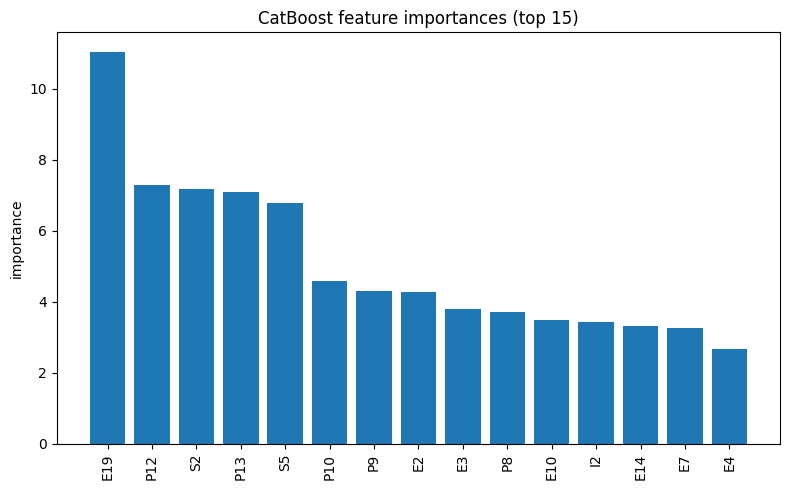

In [14]:
cat_model = stack_model.named_estimators_["CatBoost"]
importances = cat_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 15
top_idx = indices[:top_n]

plt.figure(figsize=(8, 5))
plt.bar(range(top_n), importances[top_idx])
plt.xticks(range(top_n), np.array(feature_cols)[top_idx], rotation=90)
plt.ylabel("importance")
plt.title("CatBoost feature importances (top 15)")
plt.tight_layout()
plt.show()

shows which features your CatBoost base learner thinks matter most for predicting forward_returns.

If only a handful of features dominate, you can:

simplify your feature set,

or engineer more variants around those important signals.

If importances are flat, it means the model is spreading weight across many weak predictors → again confirms “weak signal everywhere” nature of the problem.